# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import math
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
import tqdm 

digits = load_digits()

/home/feathernox/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
digits.data.shape

(1797, 64)

# Пример содержимого датасета

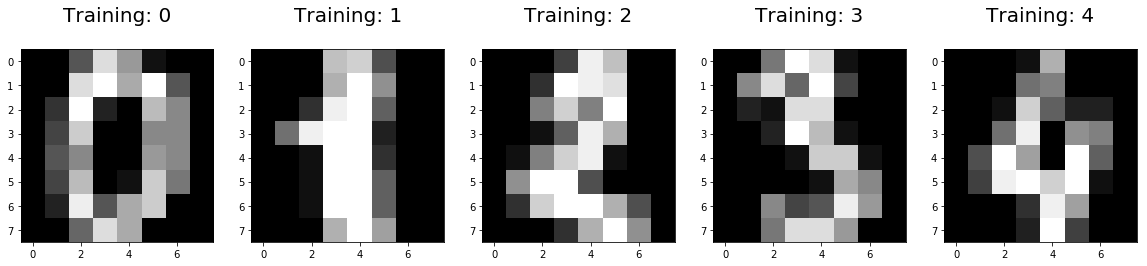

In [3]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

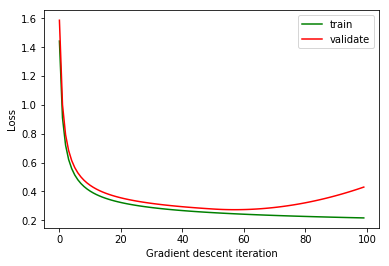

In [4]:
plt.plot(
    [1/math.log(i+2) for i in range(100)], 
    color='green', 
    label='train'
)

plt.plot(
    [1/math.log(i+2)*1.1+( (i/50.0-1)**2./5. if i>50 else 0.) for i in range(100)],
    color='red',
    label='validate')

plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

# Вернемся к задаче
## Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе. 

## Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -1 до 1, это улучшит качество нашей модели

In [5]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

x_train, x_test, y_train, y_test = train_test_split(
    (digits.data-8)/16, 
    one_hot(digits.target,10),
    test_size=0.33, 
    random_state=0
)

# Задание: реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  python и библиотеки numpy и  matplotlib

Для каждой картинки мы хотим найти вектор $(p_0,\ldots,p_{9})$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
A x + b
$$


где x - наш вектор картинки, а результат - числовой вектор размерности 10 с какими-то числами. Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x) = \frac{e^x}{\sum(e^x)}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy 

In [6]:
def softmax_draft(W, b, x):
    #todo - а можно ли написать лучше? и чем ваше решение лучше?
    tmp = np.exp(np.dot(x, W.T) + b)
    return (tmp.T / tmp.sum(axis=1)).T

**Ответ:** Действительно, можно написать лучше. Если в $x$ довольно большие значения, то могут начаться проблемы с вычислениями $softmax(x)$: например, $e^{710}$ &mdash; это уже слишком большое число, `numpy` считает его как бесконечность.

In [7]:
np.exp(710)

/home/feathernox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


inf

Поэтому вычтем $M: = \max(x)$ из всех элементов $x$. С математической точки зрения ничто не изменится:

$$
softmax(x - M) = \frac{e^{x-M}}{\sum(e^{x-M})} =
\frac{e^{-M} e^{x}}{e^{-M} \sum(e^{x})} =
\frac{e^x}{\sum(e^x)} = softmax(x)
$$

Зато $x - M$ теперь содержит неположительные числа &mdash; и обязательно содержит $0$, а $e^{x-M}$ &mdash; числа из $(0;1]$ &mdash; и обязательно содержит $1$, что гарантирует нам, что знаменатель ненулевой.

In [8]:
def softmax(W, b, x):
    '''
    Реализация подсчета softmax.
    
    Аргументы:
    x -- матрица, строки -- векторы картинок;
    W, b -- матрица и вектор, преобразовывающие x.
    
    Возвращает матрицу, строки которой -- значения softmax для соответствующих
    векторов картинок.
    '''
    y = (W @ x.T + b[:, np.newaxis]).T
    tmp = np.exp(y - y.max(axis=1)[:, np.newaxis])
    return tmp / tmp.sum(axis=1)[:, np.newaxis]

Функция кросс-энтропии:
$$H(y, \widehat{y}) = - \sum_{i} y_i \log{\widehat{y}_i},$$
где $\widehat{y} = softmax(Ax+b)$.

In [9]:
def loss(y, pred):
    '''
    Реализация кросс-энтропии.
    
    Аргументы:
    pred -- матрица, строки -- предсказанные векторы;
    y -- матрица, строки -- истинные векторы.
    
    Возвращает вектор, элементы которого -- значения функции потерь для
    соответствующих пар векторов из (pred, y).
    
    '''
    return -np.sum(y * np.log(pred), axis=1)

In [10]:
def loss_softmax(W, b, x, y):
    '''
    Реализация кросс-энтропии с вероятностями, рассчитанными как softmax.
    
    Аргументы:
    x -- матрица, строки -- векторы картинок;
    W, b -- матрица и вектор, преобразовывающие x;
    y -- матрица, строки -- истинные векторы.
    
    Возвращает вектор, элементы которого -- значения функции потерь для
    соответствующих пар векторов из (x, y).
    
    '''
    return loss(y, softmax(W, b, x))

# В данной точке x нужно научиться считать градиент. Выведите правила и посчитайте градиент в точке. Для того, чтобы выбирать градиент по всем точкам, можно его усреднить.

Положим $M = 10$ и $N = 64$.

Нам надо минимизировать функцию кросс-энтропии как функции от $A$ &mdash; матрицы размерности $M \times N$, и $b$ &mdash; вектора длины $M$. Обозначим $i$-ю строку матрицы $A$ за $A_{i*}$, а $A_{i*}x + b_i$ за $X_i$.

$$\frac{\partial X_i}{\partial a_{ij}} = x_j;
\frac{\partial X_k}{\partial a_{ij}} = 0 \; при \; k \neq i$$

$$\frac{\partial X_i}{\partial b_{i}} = 1;
\frac{\partial X_k}{\partial b_i} = 0 \; при \; k \neq i$$

$$\frac{\partial \widehat{y}_i}{\partial X_i} =
\frac{e^{X_i} (\sum^M_{l=1}{e^{X_l}} - e^{X_i})}{(\sum^M_{k=1} e^{X_k})^2} = 
softmax(X_i) \sum^M_{l=1, l \neq i} softmax(X_l) =
\widehat{y}_i (1 - \widehat{y}_i)
$$

$$\frac{\partial \widehat{y}_j}{\partial X_i} =
- \frac{e^{X_i} e^{X_j}}{(\sum^M_{k=1} e^{X_k})^2} = 
- \widehat{y}_i \; \widehat{y}_j \; при \; j \neq i
$$

$$\frac{\partial}{\partial a_{ij}} H(y, \widehat{y}) =
- \sum_{m=1}^{M} \frac{y_m}{\widehat{y}_m}
\frac{\partial \widehat{y}_m}{\partial a_{ij}} =
- \sum_{m=1}^{M} \frac{y_m}{\widehat{y}_m}
\sum^{M}_{k=1} \frac{\partial \widehat{y}_m}{\partial X_k}
\frac{\partial X_k}{\partial a_{ij}} =
- \sum_{m=1}^{M} \frac{y_m}{\widehat{y}_m} \cdot x_j
\frac{\partial \widehat{y}_m}{\partial X_i}= \\
= - x_j
\left[
\frac{y_i}{\widehat{y}_i}  \widehat{y}_i (1 - \widehat{y}_i)
- \sum^M_{l=1, l \neq i} \frac{y_l}{\widehat{y}_l} \widehat{y}_i \widehat{y}_l
\right]
= x_j [(1-y_i) \widehat{y}_i - y_i ( 1 - \widehat{y}_i)]
= x_j (\widehat{y}_i - y_i)
$$

$$\frac{\partial}{\partial b_i} H(y, \widehat{y}) =
- \sum_{m=1}^{M} \frac{y_m}{\widehat{y}_m}
\frac{\partial \widehat{y}_m}{\partial b_i} =
- \sum_{m=1}^{M} \frac{y_m}{\widehat{y}_m}
\sum^{M}_{k=1} \frac{\partial \widehat{y}_m}{\partial X_k}
\frac{\partial X_k}{\partial b_i} =
- \sum_{m=1}^{M} \frac{y_m}{\widehat{y}_m} \cdot
\frac{\partial \widehat{y}_m}{\partial X_i} = \widehat{y}_i - y_i
$$

In [11]:
def compute_gradients(out, y, x):
    '''
    Рассчитывает градиент для всех векторов картинок.
    
    Аргументы:
    x -- матрица, строки -- векторы картинок; 
    out -- матрица, строки -- предсказанные векторы;
    y -- матрица, строки -- истинные векторы.
    
    Пусть размерность векторов из x -- n, векторов из y -- m.
    Возвращает трехмерный масcив, содержащий матрицы частных производных по a_ij,
    и двумерный массив, содержащий векторы частных производных по b_i,
    i из 1..m, j из 1..n.
    
    '''
    # Добавляем столбец из единиц, чтобы считать сразу и производные
    # по a_ij, и по b_i.
    x_ext = np.hstack((x, np.ones(x.shape[0])[:, np.newaxis]))
    
    # Трехмерный массив, содержащий матрицы, соответствующие каждому из векторов x;
    # в строках матрицы находятся частные производные по a_i1, ..., a_in, b_i, 
    # сами строки соответствуют i из 1 ... m.
    res = (out - y)[:, :, np.newaxis] @ x_ext[:, np.newaxis]
    return res[:, :, :-1], res[:, :, -1]

In [12]:
def gradients(W, b, x, y):
    '''
    Рассчитывает усредненный градиент для всех векторов картинок.

    x -- матрица, строки -- векторы картинок;
    W, b -- матрица и вектор, преобразовывающие x;
    y -- матрица, строки -- истинные векторы.
    
    Пусть размерность векторов из x -- n, векторов из y -- m.
    Возвращает матрицу частных производных по a_ij,
    и вектор частных производных по b_i, i из 1..m, j из 1..n.
    
    '''
    sm = softmax(W, b, x)        
    e = compute_gradients(sm, y, x) 
    return np.mean(e[0], axis=0), np.mean(e[1], axis=0)

# Методом градиентного спуска с постоянным шагом минимизируйте loss на обучающей выборке.

In [13]:
# Реализация градиентного спуска
eta = 1

# Определяем размерность параметров.
# Всего параметров m * (n + 1), т.е. 650 в нашем случае.
m = 10
n = 64

W = np.zeros((m, n))
b = np.zeros(m)

# Будем записывать потери на каждом шаге спуска.
losses_train = []
losses_test = []

losses_train.append(loss(y_train, softmax(W, b, x_train)).mean())
losses_test.append(loss(y_test, softmax(W, b, x_test)).mean())

max_step = 5000
# Собственно сам спуск.
for i in tqdm.tqdm(range(max_step)):
    grad = gradients(W, b, x_train, y_train)
    W = W - eta * grad[0]
    b = b - eta * grad[1]
    losses_train.append(loss_softmax(W, b, x_train, y_train).mean())
    losses_test.append(loss_softmax(W, b, x_test, y_test).mean())    

losses_train = np.array(losses_train)
losses_test = np.array(losses_test)

100%|██████████| 5000/5000 [00:27<00:00, 182.93it/s]


# Нарисуйте графики ошибки (loss) от номера шага градиентного спуска. Как падала ошибка на обучающей и тестовой выборках? На каком шаге ошибка на обучающей выборке оказалась минимальной?

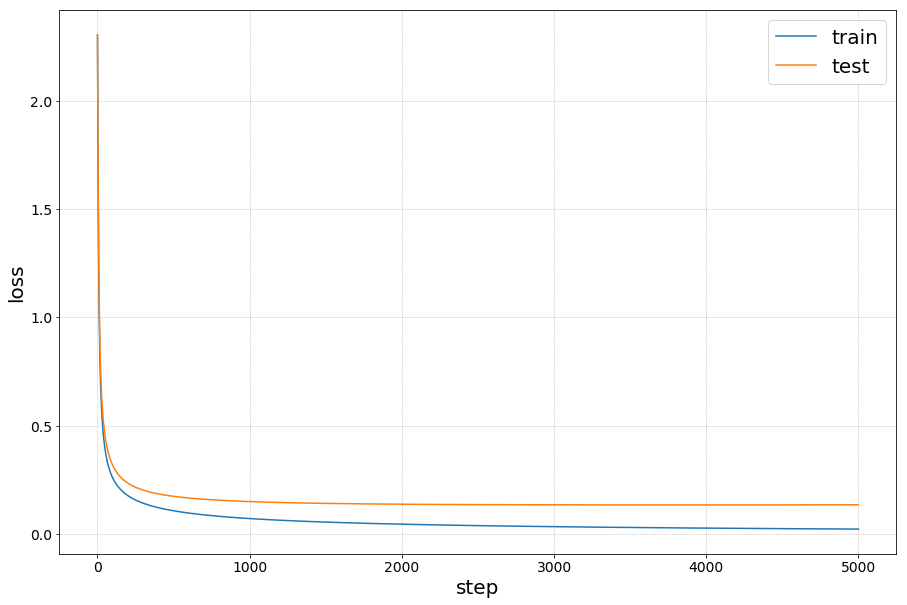

In [14]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=14) 
plt.plot(range(max_step + 1), losses_train, label='train')
plt.plot(range(max_step + 1), losses_test, label='test')
plt.legend(fontsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.grid(ls=':')
plt.show()

Обрежем график по оси $y$, чтобы было лучше видно динамику изменений при больших значениях итераций.

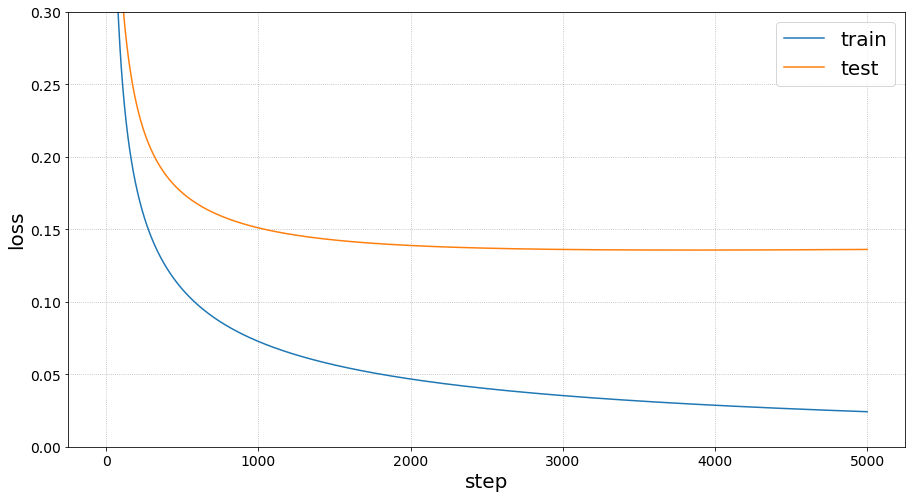

In [15]:
plt.figure(figsize=(15, 8))
plt.rc('font', size=14) 
plt.plot(range(max_step + 1), losses_train, label='train')
plt.plot(range(max_step + 1), losses_test, label='test')
plt.legend(fontsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.ylim(0, 0.3)
plt.grid(ls=':')
plt.show()

Мы видим, что на обучающей выборке ошибка всегда уменьшалась, а вот на тестовой ошибка уменьшалась до приблизительно 3000 итерации, а после практически не менялась и, возможно, даже увеличивалась.

In [16]:
print(np.argmin(losses_train))
print(np.argmin(losses_test))

5000
3840


In [17]:
# Считаем разности между ошибками на соседних шагах.
def dynamics(a):
    a = np.array(a)
    return a[:-1] - a[1:]

In [18]:
for dy in [dynamics(losses_train), dynamics(losses_test)]:
    print(np.arange(max_step)[dy > 0])
    print(np.arange(max_step)[dy == 0])
    print(np.arange(max_step)[dy < 0])
    print('\n')

[   0    1    2 ..., 4997 4998 4999]
[]
[]


[   0    1    2 ..., 3837 3838 3839]
[]
[3840 3841 3842 ..., 4997 4998 4999]




Действительно, мы видим, что на обучающей выборке минимум достигается на последней итерации, и ошибка всегда уменьшается; а на тестовой &mdash; до 3840 итерации ошибка уменьшается, после чего увеличивается. Мы видим переобучение.

# Реализуйте выбор шага градиентного спуска методом Армихо. Ускорило ли использование метода Армихо с начальными параметрами
$$ s=100, \beta=\alpha=0.5$$
# достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной?

In [19]:
def armijo (W, b, x, y, dW, db, s=1, alpha=0.5, beta=0.5):
    '''
    Рассчитывает размер шага градиентного спуска методом Армихо.

    x -- матрица, строки -- векторы картинок размерности n;
    W, b -- матрица и вектор, преобразовывающие x;
    y -- матрица, строки -- истинные векторы, размерности m;
    dW, db -- направления убывания по a_ij и по b_i соответственно;
    s, alpha, beta -- параметры алгоритма.
    
    Возвращает размер шага.
    
    '''
    f_x = loss_softmax(W, b, x, y).mean()
    nabla_W, nabla_b = gradients(W, b, x, y)
    while True:
        if loss_softmax(W + s * dW, b + s * db, x, y).mean() <= \
            f_x + alpha * s * ((nabla_W * dW).sum() + (nabla_b * db).sum()):
            return s
        s *= beta

In [20]:
# Определяем размерность параметров.
# Всего параметров m * (n + 1), т.е. 650 в нашем случае.
m = 10
n = 64

W = np.zeros((m, n))
b = np.zeros(m)

# Будем записывать потери на каждом шаге спуска.
losses_train = []
losses_train_armijo = []
losses_test = []
losses_test_armijo = []

losses_train.append(loss(y_train, softmax(W, b, x_train)).mean())
losses_train_armijo.append(losses_train[0])
losses_test.append(loss(y_test, softmax(W, b, x_test)).mean())
losses_test_armijo.append(losses_test[0])

max_step = 5000

# Реализация градиентного спуска c константным шагом.
eta = 100

for i in tqdm.tqdm(range(max_step)):
    grad = gradients(W, b, x_train, y_train)
    W = W - eta * grad[0]
    b = b - eta * grad[1]
    losses_train.append(loss_softmax(W, b, x_train, y_train).mean())
    losses_test.append(loss_softmax(W, b, x_test, y_test).mean())    

# Снова задаем начальную точку.
W = np.zeros((m, n))
b = np.zeros(m)

# Реализация градиентного спуска c выбором шага методом Армихо.
for i in tqdm.tqdm(range(max_step)):
    grad = gradients(W, b, x_train, y_train)
    eta = armijo (W, b, x_train, y_train, -grad[0], -grad[1], s=100)
    W = W - eta * grad[0]
    b = b - eta * grad[1]
    losses_train_armijo.append(loss_softmax(W, b, x_train, y_train).mean())
    losses_test_armijo.append(loss_softmax(W, b, x_test, y_test).mean())

100%|██████████| 5000/5000 [01:03<00:00, 79.00it/s]


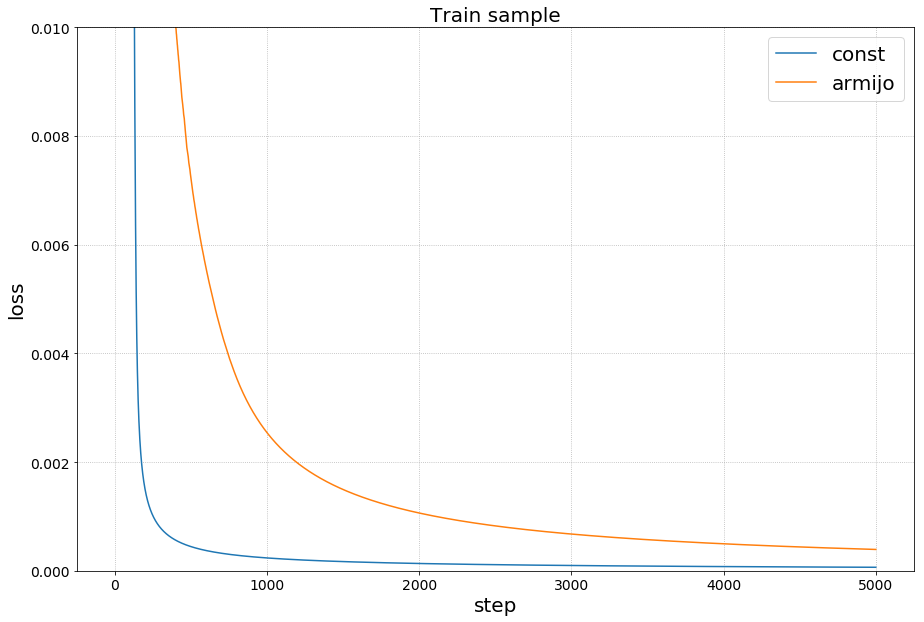

In [21]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=14) 
plt.plot(range(max_step + 1), losses_train, label='const')
plt.plot(range(max_step + 1), losses_train_armijo, label='armijo')
plt.legend(fontsize=20)
plt.title('Train sample', fontsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.ylim((0, 0.01))
plt.grid(ls=':')
plt.show()

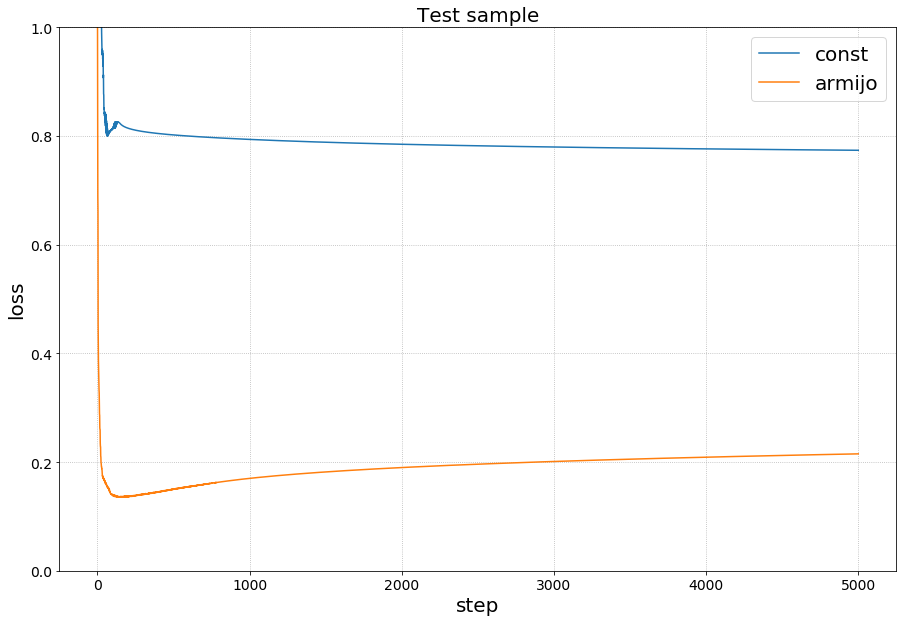

In [22]:
plt.figure(figsize=(15, 10))
plt.rc('font', size=14) 
plt.plot(range(max_step + 1), losses_test, label='const')
plt.plot(range(max_step + 1), losses_test_armijo, label='armijo')
plt.legend(fontsize=20)
plt.title('Test sample', fontsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.ylim((0, 1))
plt.grid(ls=':')
plt.show()

In [23]:
print(np.argmin(losses_train))
print(np.argmin(losses_test))
print(np.argmin(losses_train_armijo))
print(np.argmin(losses_test_armijo))

5000
5000
5000
160


**Вывод:** Градиентный спуск с выбором шага по методу Армихо с начальными параметрами $s=100, \beta=\alpha=0.5$ сходится к минимуму дольше, чем с фиксированным шагом $s=100$, на обучающей выборке, но быстрее на валидационной.

При этом разница в показаниях на валидационной выборке достаточно велика &mdash; значение функции потерь при использовании Армихо имеет значение около $0.2$, а при фиксированном шаге &mdash; $0.8$. Возможно, спуск сходился к разным локальным минимумам, и градиентный спуск с фиксированным шагом "проскочил" более выгодный для валидационной выборки минимум.

Однако метод Армихо оказался более склонным к переобучению &mdash; на 160-й итерации он достигает минимума функции потерь на валидационной выборки, после чего функция потерь начинает возрастать. Спуск с фиксированным шагом, хоть и идет на возрастание в районе 100-й итерации, в конце концов идет на убывание и даже оказывается меньше значения на 100 итерации.

# Какую долю картинок из валидационной выборки удается предсказать правильно? Приведите примеры из валидационной выборки, где модель ошибается и где работает правильно

Используем градиентный спуск с постоянным шаго $\eta = 1$.

In [24]:
# Реализация градиентного спуска
eta = 1

# Определяем размерность параметров.
# Всего параметров m * (n + 1), т.е. 650 в нашем случае.
m = 10
n = 64

W = np.zeros((m, n))
b = np.zeros(m)

# Будем записывать потери на каждом шаге спуска.
losses_train = []
losses_test = []

losses_train.append(loss(y_train, softmax(W, b, x_train)).mean())
losses_test.append(loss(y_test, softmax(W, b, x_test)).mean())

max_step = 5000
# Собственно сам спуск.
for i in tqdm.tqdm(range(max_step)):
    grad = gradients(W, b, x_train, y_train)
    W = W - eta * grad[0]
    b = b - eta * grad[1]
    losses_train.append(loss_softmax(W, b, x_train, y_train).mean())
    losses_test.append(loss_softmax(W, b, x_test, y_test).mean())    

losses_train = np.array(losses_train)
losses_test = np.array(losses_test)

100%|██████████| 5000/5000 [00:37<00:00, 133.06it/s]


In [25]:
def prediction(W, b, x):
    '''
    Предсказывает класс, к которому принадлежит картинка
    --- выбирает максимум среди вероятностей, рассчитанных как softmax(Wx + b).

    x -- матрица, строки -- векторы картинок размерности n;
    W, b -- матрица и вектор, преобразовывающие x;
    
    Возвращает вектор номеров класса, соответствующих каждой картинке.
    
    '''
    return np.argmax(softmax(W, b, x), axis=1)

In [26]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [27]:
y_true = np.argmax(y_test, axis=1)
y_pred = prediction(W, b, x_test)
print(round(accuracy(y_true, y_pred), 2))

0.95


**Ответ:** Доля правильных ответов составляет $95\%$.

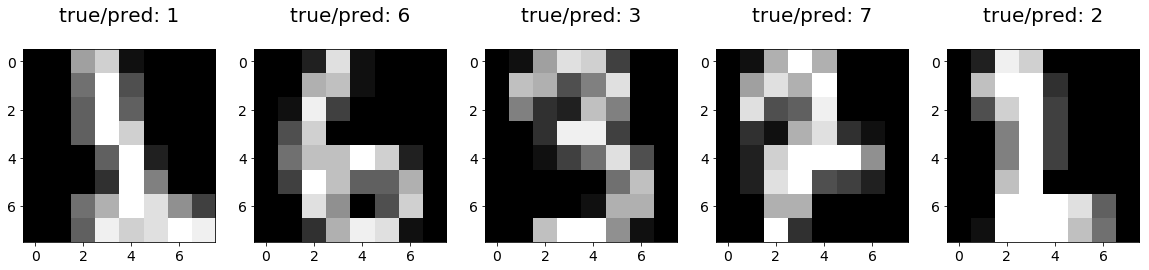

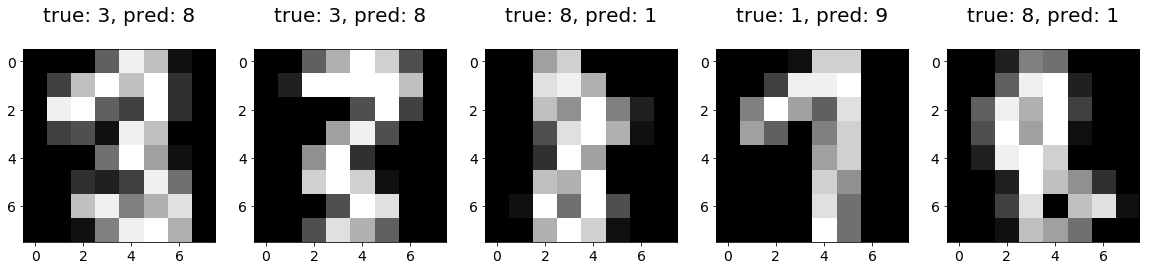

In [29]:
np.random.seed(seed=13)
hits = np.where(y_true == y_pred)[0]
misses = np.where(y_true != y_pred)[0]
np.random.shuffle(hits)
np.random.shuffle(misses)

plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(x_test[hits[:5]], y_true[hits[:5]])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('true/pred: %i\n' % label, fontsize=20)
plt.show()

plt.figure(figsize=(20, 4))
plt.title('Wrong predictions', fontsize=20)
for index, (image, label_t, label_f) in enumerate(zip(x_test[misses[:5]],
                                    y_true[misses[:5]], y_pred[misses[:5]])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('true: %i, pred: %i\n' % (label_t, label_f), fontsize=20)